In [2]:
%reset

In [3]:
from sklearn.datasets import fetch_openml
import numpy as np
import time
import torch
from scipy.optimize import linprog
from qpsolvers import solve_qp
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
from torch.autograd import Function
import torch.nn as nn
from sklearn.model_selection import train_test_split
import sys
import importlib
from torch.nn.utils import clip_grad_norm_
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

Analysis of COMPAS dataset with standard optimization algorithm without incorporating any fairness measures.

In [4]:
raw_data = pd.read_csv("compas-scores-two-years.csv")

In [5]:
df = raw_data[['age', 'c_charge_degree', 'race', 'age_cat', 'score_text', 'sex', 'priors_count',
               'days_b_screening_arrest', 'decile_score', 'is_recid', 'two_year_recid', 'c_jail_in', 'c_jail_out']]
df = df[(df['days_b_screening_arrest'] <= 30) & (df['days_b_screening_arrest'] >= -30) &
        (df['is_recid'] != -1) & (df['c_charge_degree'] != "O") & (df['score_text'] != 'N/A')]

In [6]:
df['length_of_stay'] = pd.to_datetime(df['c_jail_out']) - pd.to_datetime(df['c_jail_in'])
df['length_of_stay'] = df['length_of_stay'].dt.total_seconds() / 3600

In [7]:
null_counts = df.isnull().sum()
print(null_counts)

age                        0
c_charge_degree            0
race                       0
age_cat                    0
score_text                 0
sex                        0
priors_count               0
days_b_screening_arrest    0
decile_score               0
is_recid                   0
two_year_recid             0
c_jail_in                  0
c_jail_out                 0
length_of_stay             0
dtype: int64


In [8]:
# Calculate length_of_stay and correlation
correlation = df['length_of_stay'].corr(df['decile_score'])
print(f"Correlation between length_of_stay and decile_score: {correlation}")

Correlation between length_of_stay and decile_score: 0.20741201943031573


In [9]:
race_distribution = df['race'].value_counts(normalize=True) * 100
print(race_distribution)

# Summary of score_text
print(df['score_text'].describe())

# Cross-tabulation of sex and race
sex_race_cross_tab = pd.crosstab(df['sex'], df['race'])
print(sex_race_cross_tab)

# Summary of sex
print(df['sex'].describe())

# Percentage of two_year_recid == 1
recid_percentage = len(df[df['two_year_recid'] == 1]) / len(df) * 100
print(f"Percentage of two_year_recid == 1: {recid_percentage:.2f}%")

African-American    51.441996
Caucasian           34.073234
Hispanic             8.246922
Other                5.557356
Asian                0.502268
Native American      0.178224
Name: race, dtype: float64
count     6172
unique       3
top        Low
freq      3421
Name: score_text, dtype: object
race    African-American  Asian  Caucasian  Hispanic  Native American  Other
sex                                                                         
Female               549      2        482        82                2     58
Male                2626     29       1621       427                9    285
count     6172
unique       2
top       Male
freq      4997
Name: sex, dtype: object
Percentage of two_year_recid == 1: 45.51%


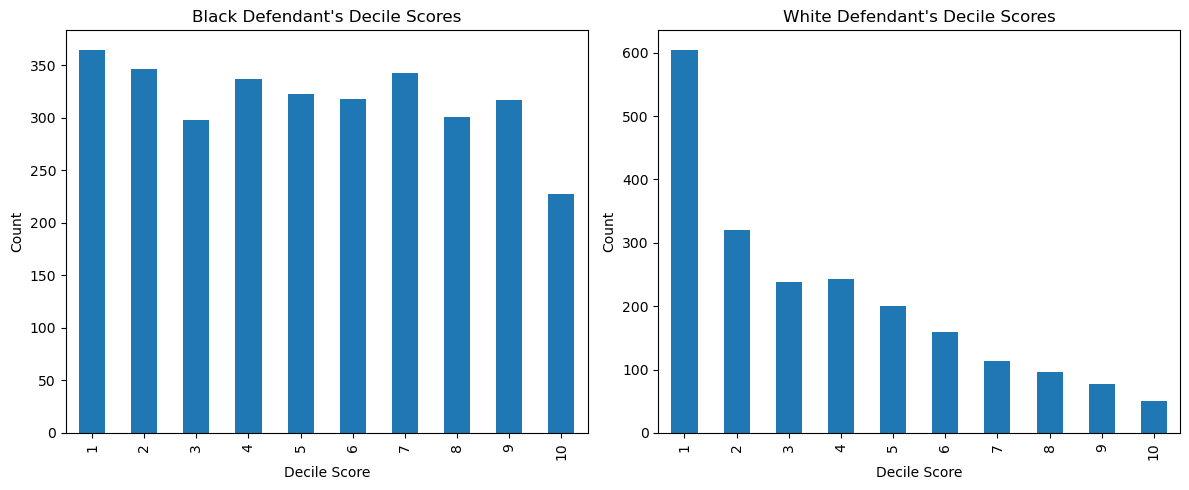

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

# Plot for African-American
pblack = df[df['race'] == "African-American"]['decile_score'].value_counts(
).sort_index().plot(kind='bar', ax=axes[0])
pblack.set_title("Black Defendant's Decile Scores")
pblack.set_xlabel('Decile Score')
pblack.set_ylabel('Count')

# Plot for Caucasian
pwhite = df[df['race'] == "Caucasian"]['decile_score'].value_counts(
).sort_index().plot(kind='bar', ax=axes[1])
pwhite.set_title("White Defendant's Decile Scores")
pwhite.set_xlabel('Decile Score')
pwhite.set_ylabel('Count')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

In [11]:
df_needed = df[(df['race'] == 'Caucasian') | (df['race'] =='African-American')]

In [12]:
# Categorizing
df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
df_needed['race_code'] = pd.Categorical(df_needed['race']).codes
df_needed['gender_code'] = pd.Categorical(df_needed['sex']).codes
df_needed['score_code'] = pd.Categorical(df_needed['score_text']).codes
df_needed['charge_degree_code'] = pd.Categorical(
    df_needed['c_charge_degree']).codes

# Releveling factors
# df['age_factor'] = df['age_factor'].cat.reorder_categories(['Greater than 45', '25 - 45', 'Less than 25'], ordered=True)
# df['race_factor'] = df['race_factor'].cat.reorder_categories(['African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other'], ordered=True)
# df['gender_factor'] = df['gender_factor'].cat.reorder_categories(['Female', 'Male'], ordered=True)

/tmp/ipykernel_45499/266898286.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['crime_code'] = pd.Categorical(df_needed['c_charge_degree']).codes
/tmp/ipykernel_45499/266898286.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_needed['age_code'] = pd.Categorical(df_needed['age_cat']).codes
/tmp/ipykernel_45499/266898286.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats 

In [13]:
in_df = df_needed[['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code']]
out_df = df_needed[['two_year_recid']]

In [14]:
X_train, X_val, Y_train, Y_val = train_test_split(torch.tensor(in_df.values), torch.tensor(out_df.values), test_size=0.2, random_state=42)

In [15]:
class SimpleClassifier(nn.Module):
    def __init__(self, layer_sizes):
        super(SimpleClassifier, self).__init__()

        # Create a list of linear layers based on layer_sizes
        self.layers = nn.ModuleList()
        self.layer_norms = nn.ModuleList()
        for i in range(len(layer_sizes) - 1):
            self.layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu((layer(x)))
        x = torch.sigmoid(self.layers[-1](x))
        return x

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_val)

# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(Y_val, dtype=torch.float32)

# Create DataLoader for training and testing sets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/tmp/ipykernel_45499/1797719004.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(Y_train, dtype=torch.float32)
/tmp/ipykernel_45499/1797719004.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test_tensor = torch.tensor(Y_val, dtype=torch.float32)


In [19]:
# Instantiate the model
input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 8
op_size = 1
layer_sizes = [input_size, hidden_size1, hidden_size2, op_size]
model = SimpleClassifier(layer_sizes)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500

In [20]:
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1, 1))
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

Epoch 1/500, Loss: 0.6845712065696716
Epoch 2/500, Loss: 0.6493380069732666
Epoch 3/500, Loss: 0.6666020750999451
Epoch 4/500, Loss: 0.6725193858146667
Epoch 5/500, Loss: 0.5915878415107727
Epoch 6/500, Loss: 0.5603991150856018
Epoch 7/500, Loss: 0.5807744264602661
Epoch 8/500, Loss: 0.7138601541519165
Epoch 9/500, Loss: 0.5847285389900208
Epoch 10/500, Loss: 0.5785630345344543
Epoch 11/500, Loss: 0.5693435072898865
Epoch 12/500, Loss: 0.68707674741745
Epoch 13/500, Loss: 0.48973575234413147
Epoch 14/500, Loss: 0.5607801079750061
Epoch 15/500, Loss: 0.588529109954834
Epoch 16/500, Loss: 0.6250631213188171
Epoch 17/500, Loss: 0.5298442840576172
Epoch 18/500, Loss: 0.5686562657356262
Epoch 19/500, Loss: 0.595166802406311
Epoch 20/500, Loss: 0.5744359493255615
Epoch 21/500, Loss: 0.5858511924743652
Epoch 22/500, Loss: 0.6581317782402039
Epoch 23/500, Loss: 0.5996608734130859
Epoch 24/500, Loss: 0.6100982427597046
Epoch 25/500, Loss: 0.5523342490196228
Epoch 26/500, Loss: 0.591797351837158

In [21]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    pred = []
    lab = []
    x_val = []
    out = []
    x_scaled = []
    start = 0
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predictions = (outputs >= 0.5).float()
        total += labels.size(0)
        end = start + len(labels)
        x_val.append(X_val[start:end, :])
        x_scaled.append(inputs)
        pred.append(predictions.flatten())
        lab.append(labels.flatten())
        out.append(outputs.flatten().float())
        correct += (predictions == labels.view(-1, 1)).sum().item()
        start = end
    accuracy = correct / total
    print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 66.67%


In [22]:
pred = torch.cat(pred, dim=0)
lab = torch.cat(lab, dim=0)
out = torch.cat(out, dim=0)
tensor_list = []
for i in range(len(x_val)):
    for ip_ten in (x_val[i]):
      tensor_list.append(np.array(ip_ten))
tensor_list = np.array(tensor_list)
pred = np.array(pred)
lab = np.array(lab)
out = np.array(out)

In [23]:
tensor_list_scaled = []
for i in range(len(x_scaled)):
    for ip_ten in (x_scaled[i]):
      tensor_list_scaled.append(np.array(ip_ten))
tensor_list_scaled = np.array(tensor_list_scaled)

In [24]:
df_out_scaled = pd.DataFrame(tensor_list_scaled, columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code'])
df_out_scaled["raw_out"] = (out)
df_out_scaled["true_labels"] = (lab).astype(int)

In [25]:
df_out = pd.DataFrame(tensor_list, columns=['priors_count', 'score_code', 'age_code', 'gender_code', 'race_code', 'crime_code', 'charge_degree_code'])
df_out["pred_labels"] = (pred).astype(int)
df_out["true_labels"] = (lab).astype(int)

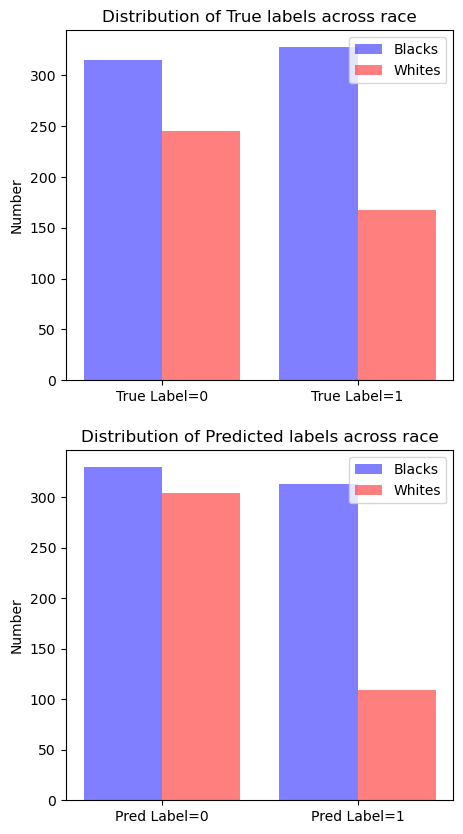

In [32]:
import numpy as np
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(5, 10))

# Sample data
categories1 = ['True Label=0', 'True Label=1']
values1 = [len(df_out[(df_out["race_code"]==0) & (df_out["true_labels"]==0)]), len(df_out[(df_out["race_code"]==0) & (df_out["true_labels"]==1)])]
values2 = [len(df_out[(df_out["race_code"]==1) & (df_out["true_labels"]==0)]), len(df_out[(df_out["race_code"]==1) & (df_out["true_labels"]==1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories1))

# Plot the first group of bars (Bars 1 and 2)
ax[0].bar(index, values1, color='blue', width=bar_width,
        label='s=black', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[0].bar(index + bar_width, values2, color='red',
        width=bar_width, label='s=white', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[0].set_xticks(index + bar_width / 2)
ax[0].set_xticklabels(categories1)
# Add labels and legend
# plt.xlabel('Categories')
ax[0].set_ylabel("Number")
ax[0].set_title('Distribution of True labels across race')
ax[0].legend()


categories2 = ['Pred Label=0', 'Pred Label=1']
values3 = [len(df_out[(df_out["race_code"]==0) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["race_code"]==0) & (df_out["pred_labels"]==1)])]
values4 = [len(df_out[(df_out["race_code"]==1) & (df_out["pred_labels"]==0)]), len(df_out[(df_out["race_code"]==1) & (df_out["pred_labels"]==1)])]

bar_width = 0.4  # Adjust the width based on your preference
index = np.arange(len(categories2))

# Plot the first group of bars (Bars 1 and 2)
ax[1].bar(index, values3, color='blue', width=bar_width,
        label='s=black', alpha=0.5)

# Plot the second group of bars (Bars 3 and 4)
ax[1].bar(index + bar_width, values4, color='red',
        width=bar_width, label='s=white', alpha=0.5)

# Adjust the x-axis ticks and labels
ax[1].set_xticks(index + bar_width / 2)
ax[1].set_xticklabels(categories2)

# Add labels and legend
# plt.xlabel('Categories')
ax[1].set_ylabel("Number")
ax[1].set_title('Distribution of Predicted labels across race')
ax[1].legend()


In [30]:
tp_black = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 0)])
fp_black = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 0)])
tn_black = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 0)])
fn_black = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 0)])

tp_white = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 1)])
fp_white = len(df_out[(df_out['pred_labels'] == 1) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 1)])
tn_white = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 0) & (df_out['race_code'] == 1)])
fn_white = len(df_out[(df_out['pred_labels'] == 0) & (df_out['true_labels'] == 1) & (df_out['race_code'] == 1)])

In [31]:
fpr_black = fp_black/(fp_black + tn_black)
tpr_black = tp_black/(tp_black + fn_black)
fpr_white = fp_white/(fp_white + tn_white)
tpr_white = tp_white/(tp_white + fn_white)

print("FPR black", fpr_black)
print("TPR black", tpr_black)
print("FPR white", fpr_white)
print("TPR white", tpr_white)

FPR black 0.31746031746031744
TPR black 0.649390243902439
FPR white 0.15918367346938775
TPR white 0.4166666666666667
